In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from utils.common_plot_tetha import plot_model
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_selector, make_column_transformer, ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, make_scorer, confusion_matrix, fbeta_score
from sklearn.feature_selection import SelectFromModel
from pprint import pprint
import warnings
warnings.filterwarnings("ignore") 
from sklearn import set_config
set_config(display='diagram')

# 1. Read Data

In [25]:
df = pd.read_csv('bank+marketing/bank_clean.csv')

# 2. Train Test Split

In [26]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['balance','y','previous','poutcome','default'], axis=1), df['y'], test_size = 0.3, random_state = 42)

# 3. Column Transformation
- OneHotEncoder for 'job','marital', 'contact', 'default', 'housing', 'loan', 'contact', 'month','poutcome'
- OrdinalEncoder for education

In [27]:

education_categories = [['illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'university.degree','professional.course']]
one_hot_encoding_features = ['job','marital', 'contact', 'housing', 'loan', 'month']

transformer = make_column_transformer(    
    (OneHotEncoder(),one_hot_encoding_features),
    (OrdinalEncoder(categories=education_categories, unknown_value=-1, handle_unknown='use_encoded_value'),['education']),
    remainder = StandardScaler()
)

# 4. Pipeline

In [28]:
pipeline = Pipeline([
    ('transformer', transformer),     
    ('classifier', DecisionTreeClassifier(random_state = 42))
])

## 4.1 Plain Vanila fitting

In [29]:
pipeline.fit(X_train,y_train);

In [30]:
depth_1 = pipeline.named_steps['classifier'].get_depth()
train_acc = pipeline.score(X_train, y_train)
test_acc = pipeline.score(X_test, y_test)

In [31]:
print(f'Training Accuracy: {train_acc: .2f}')
print(f'Test Accuracy:     {test_acc: .2f}')
print(f'Depth of tree:      {depth_1}')

Training Accuracy:  1.00
Test Accuracy:      0.88
Depth of tree:      29


In [32]:
transformer = pipeline.named_steps['transformer']
transform_column = [' '.join(trans.split("__")[1].split('_')) for trans in transformer.get_feature_names_out()]

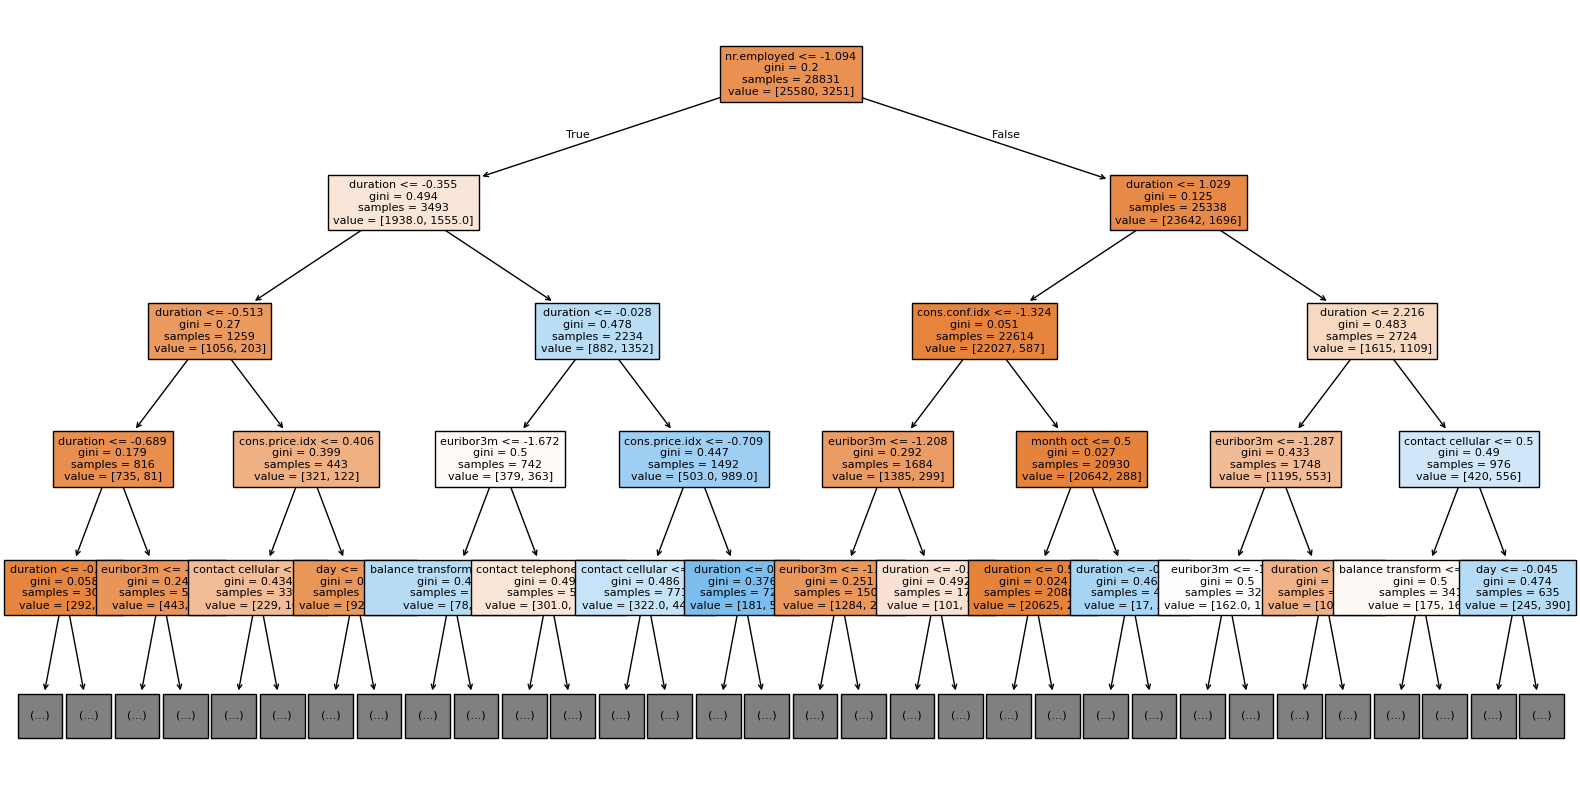

In [33]:
fix, ax = plt.subplots(figsize=(20, 10), ncols=1)
tree1_colored = plot_tree(pipeline.named_steps['classifier'], feature_names = transform_column, max_depth=4, fontsize=8, filled=True)

## 4.2. Determining parameters for DecisionTreeClassifier

In [34]:
def DetermineParameter(decision_classifier, parameter, parameters_list):
    train_accuracies = []
    test_accuracies = []

    for para in parameters_list:
        kwargs = {
            "random_state": 42,
            "class_weight":{'yes':1, 'no':9},
            parameter: para
        }
        pipeline = pipeline = Pipeline([
                    ('transformer', transformer),     
                    ('classifier', decision_classifier(**kwargs))
        ])    
        pipeline.fit(X_train, y_train)
        y_train_pred = pipeline.predict(X_train)
        y_test_pred = pipeline.predict(X_test)
        
        # Calculate and collect accuracies
        train_accuracies.append(accuracy_score(y_train, y_train_pred))
        test_accuracies.append(accuracy_score(y_test, y_test_pred))

    plt.figure(figsize=(20, 8))
    plt.plot(parameters_list, train_accuracies, label='Training Accuracy', marker='o')
    plt.plot(parameters_list, test_accuracies, label='Test Accuracy', marker='o')
    plt.xlabel(f'{parameter.replace("_"," ")}')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy vs. Tree {parameter.replace("_"," ")}')
    plt.legend()
    plt.grid(True)
    plt.show()

### max_depth
- Purpose: Limits the depth (number of levels) of the tree.<br>
- Tip: A very deep tree can overfit; setting a maximum depth helps control model complexity.

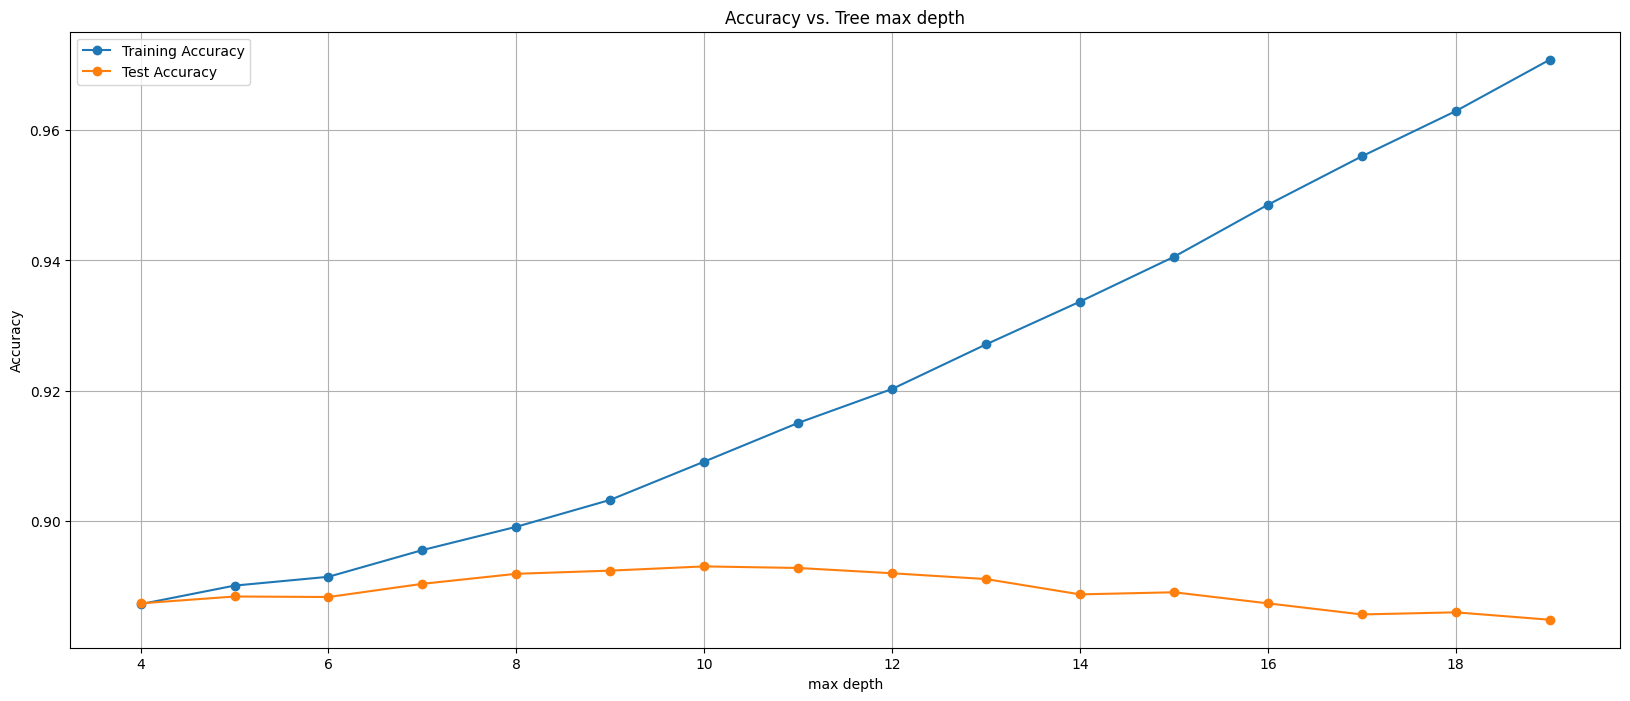

In [35]:
DetermineParameter(DecisionTreeClassifier,"max_depth", range(4,20))

### min_samples_split
- Purpose: The minimum number of samples required to split an internal node.
- Tip: Increasing this value can make the tree more general and reduce overfitting.

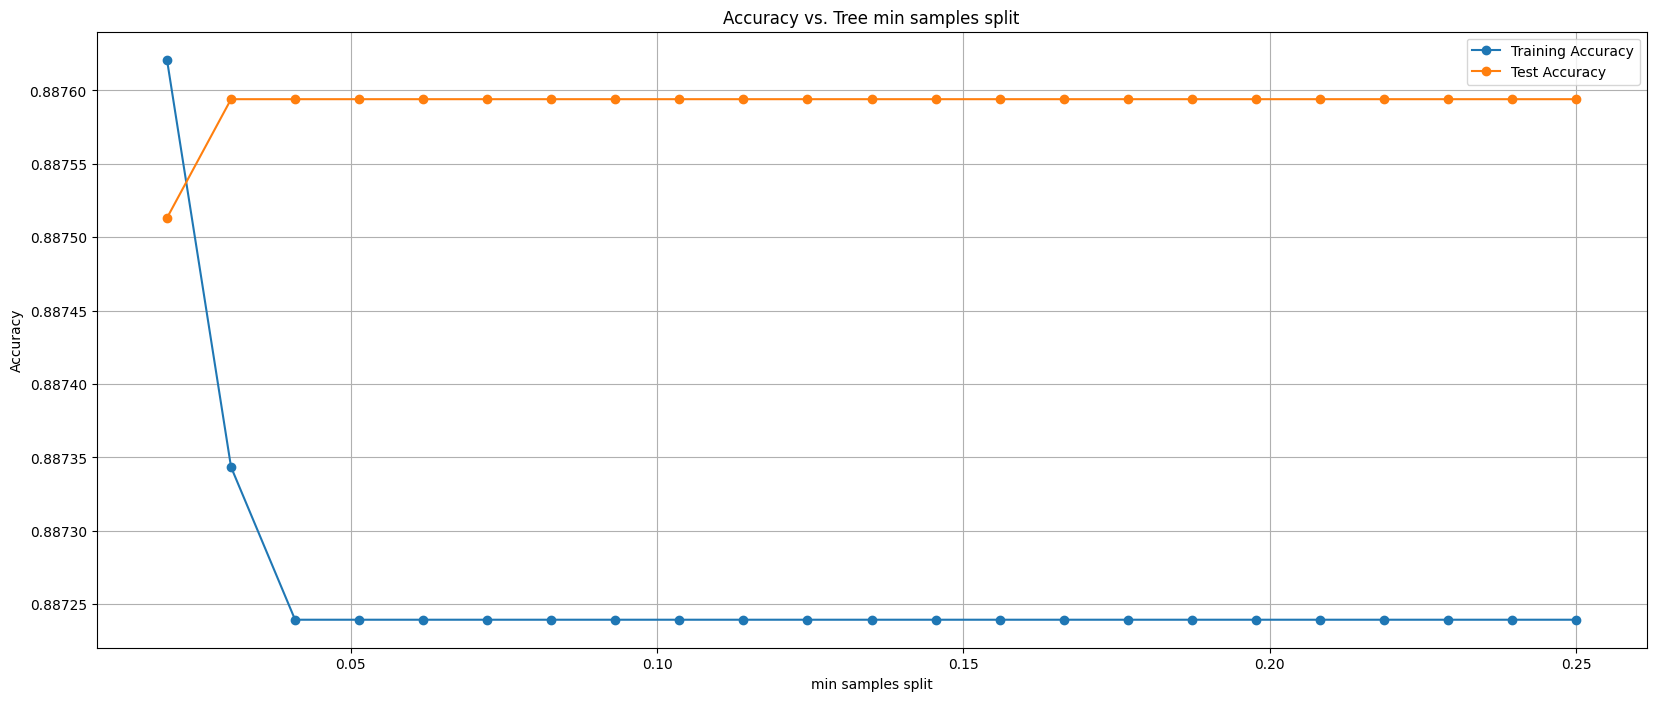

In [36]:
DetermineParameter(DecisionTreeClassifier,"min_samples_split", np.linspace(0.02,0.25,23))

### min_samples_leaf
- Purpose: The minimum number of samples required to be at a leaf node.
- Tip: Larger values can reduce variance (smoothing the model), which might help avoid overfitting.

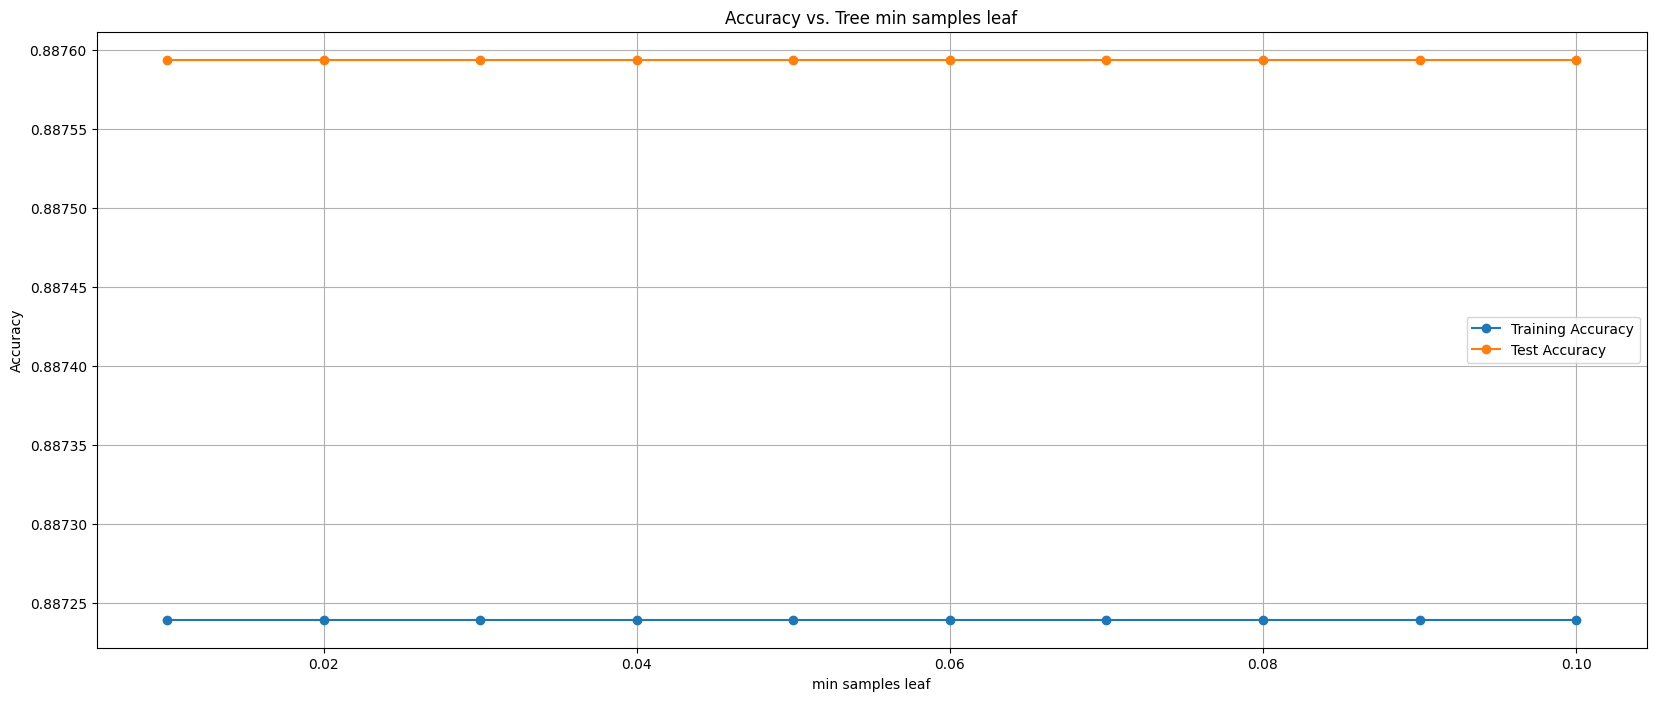

In [37]:
DetermineParameter(DecisionTreeClassifier,"min_samples_leaf", np.linspace(0.01,0.1,10))

### max_leaf_nodes
- Purpose: Limits the number of leaf nodes in the tree.
- Tip: It can be used as an alternative to max_depth to control complexity.

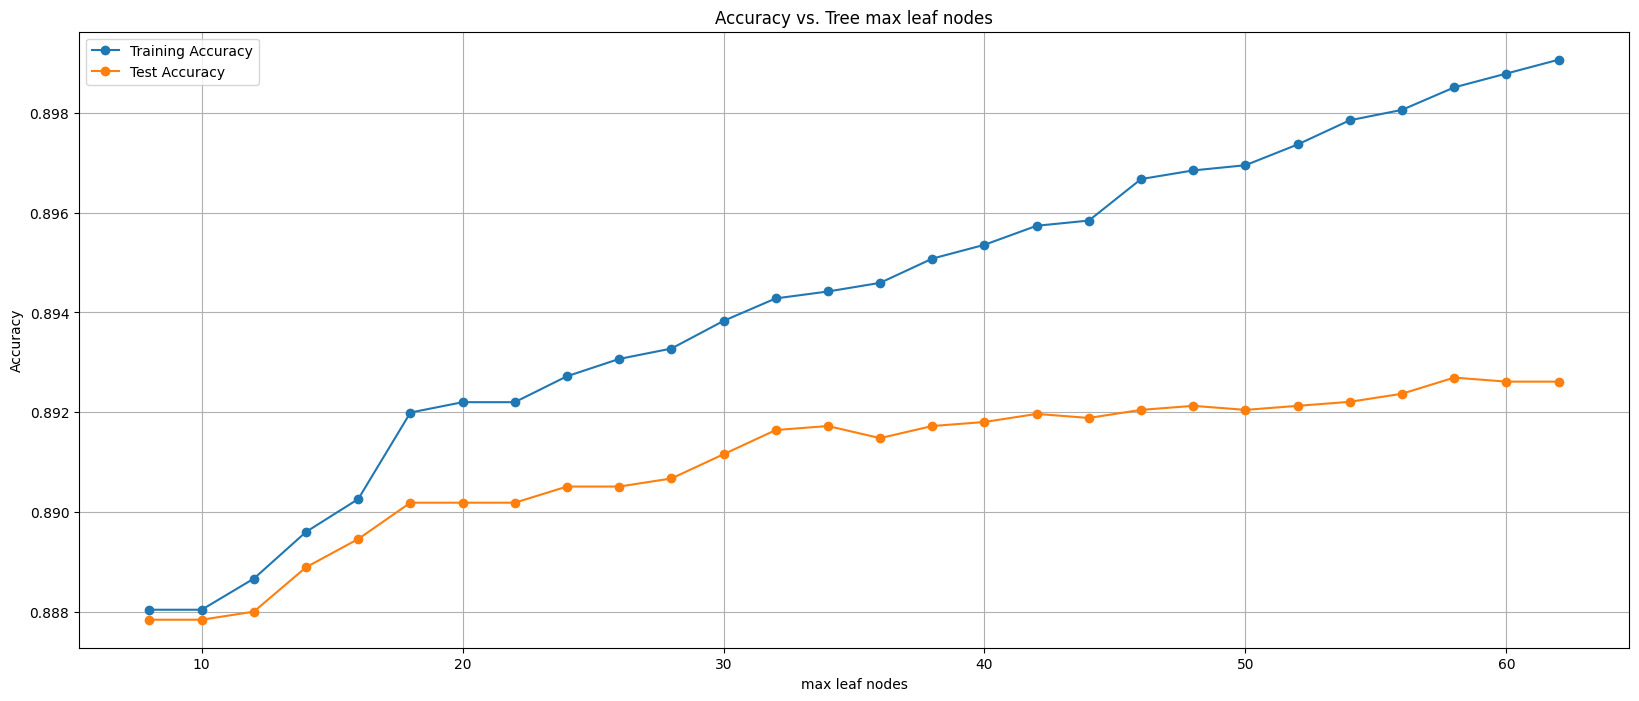

In [38]:
DetermineParameter(DecisionTreeClassifier,"max_leaf_nodes", range(8,64,2))

### max_features
- Purpose: The number of features to consider when looking for the best split.

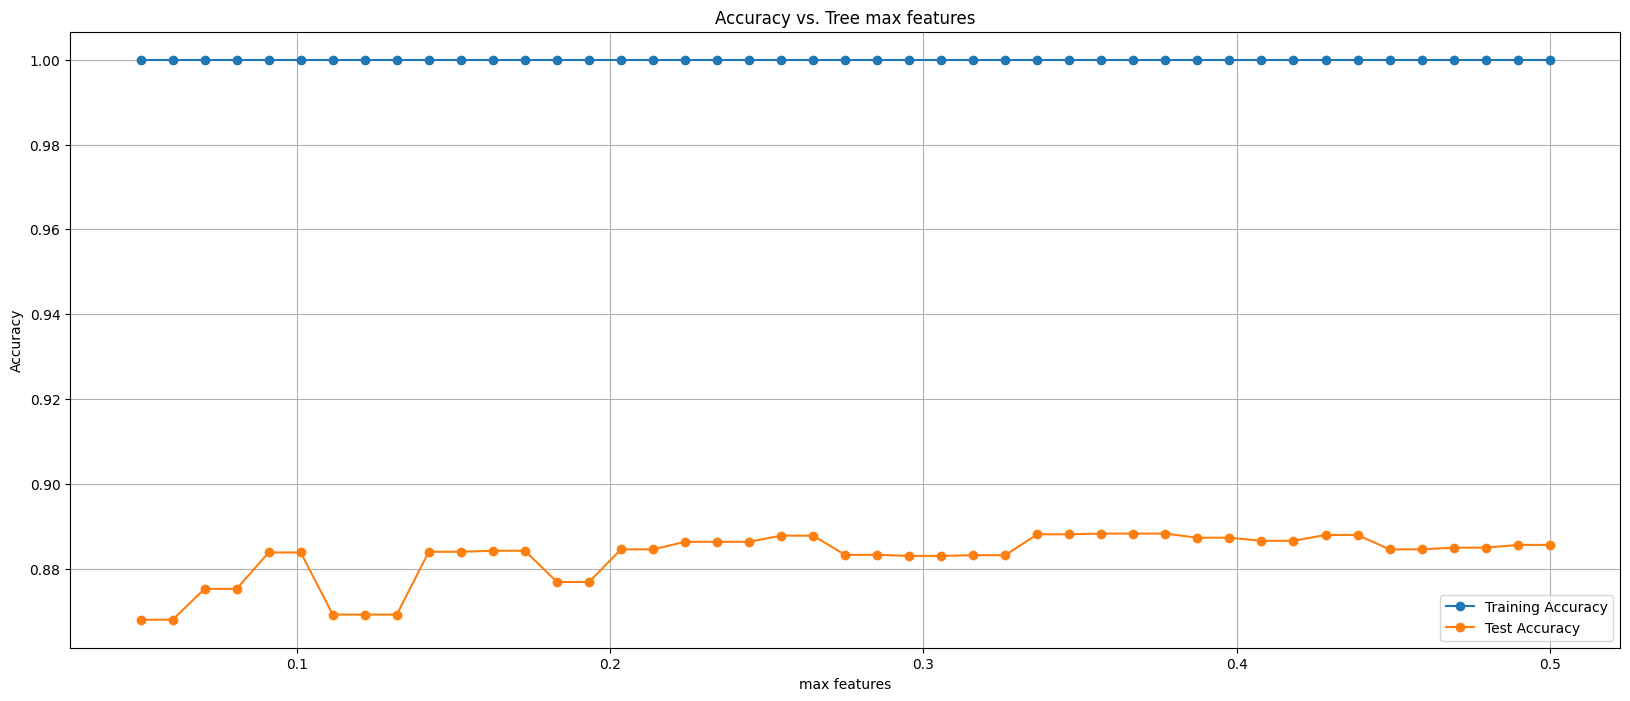

In [39]:
DetermineParameter(DecisionTreeClassifier,"max_features", np.linspace(0.05, 0.5, 45))

### min_impurity_decrease
- A node will be split if this split induces a decrease of the impurity greater than or equal to this value.

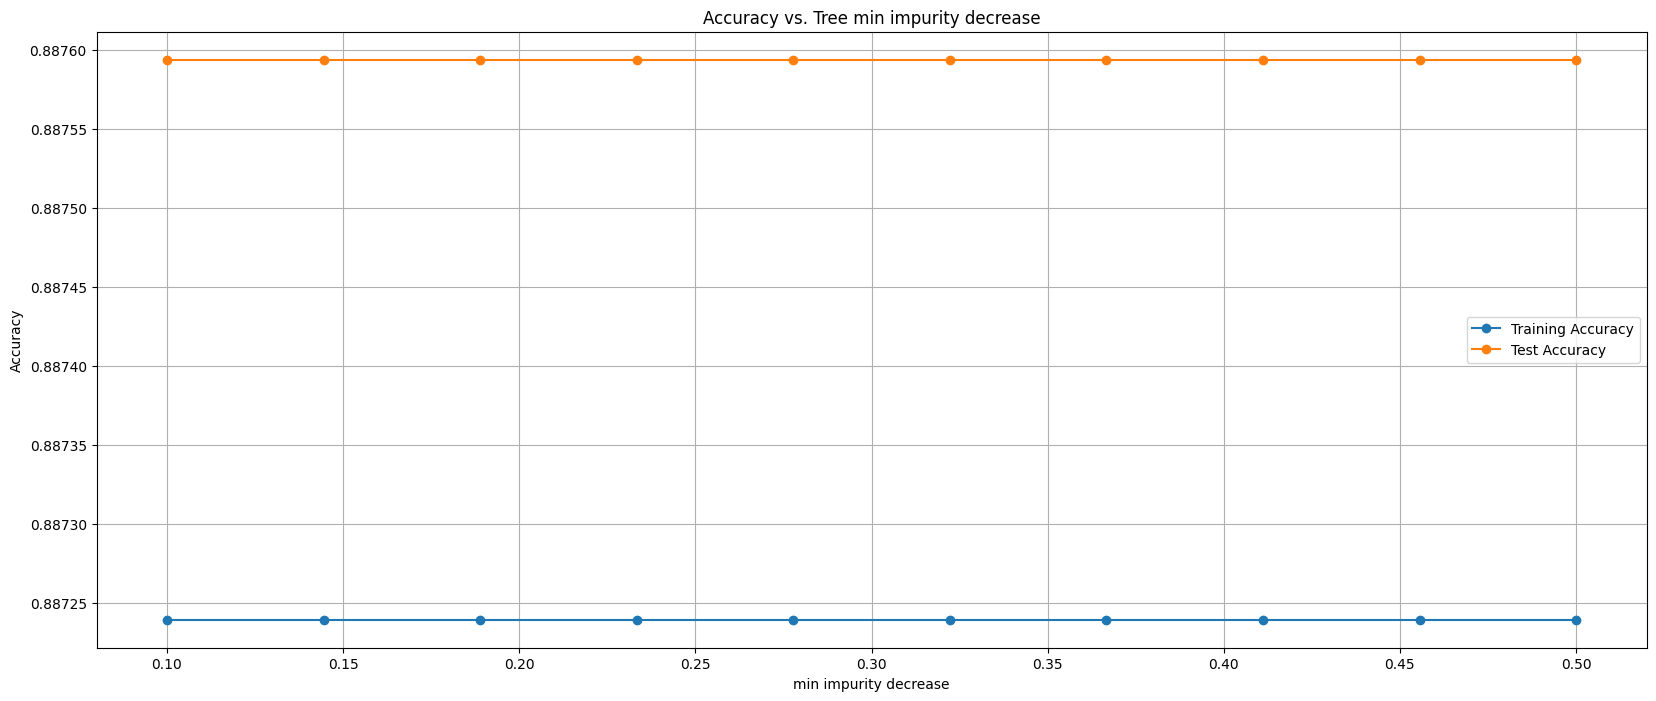

In [40]:
DetermineParameter(DecisionTreeClassifier,"min_impurity_decrease", np.linspace(0.1, 0.5, 10))

# 5. Pipeline - 1

<div class="alert alert-block alert-info">
- Metric used here is "fbeta_score"<br>    
- Lastly used DecisionTreeClassifier  <br>
- HyperParameter Tuning using GridSearchCV<br>
</div>

In [41]:
pipeline1 = Pipeline([
    ('transformer', transformer),     
    ('classifier', DecisionTreeClassifier(random_state = 42))
])

## 5.1 GridSearchCV

In [42]:
params1 = [
    {
         'classifier__criterion': ["gini", "entropy"],
         'classifier__max_depth': list(range(8, 14, 1)),
         'classifier__min_samples_split': np.linspace(0.15, 0.25, 10)
    },   
    {
        'classifier__criterion': ["gini", "entropy"],        
        'classifier__min_samples_split': np.linspace(0.02,0.06,4),
    },
    {
        'classifier__criterion': ["gini", "entropy"],
        'classifier__min_samples_leaf': [0.02,0.04,0.06]
    },
    {
        'classifier__criterion': ["gini", "entropy"],
        'classifier__max_leaf_nodes':list(range(54, 66, 2)),
    },
     {
         'classifier__criterion': ["gini", "entropy"],  
         'classifier__max_depth': list(range(8, 14, 1)),
     }
]

In [43]:
cv1 = GridSearchCV(pipeline1, param_grid=params1, n_jobs=-1, scoring=make_scorer(fbeta_score, beta=2, pos_label='yes'))

## 5.2. Fitting the LogisticRegression Model

In [44]:
cv1.fit(X_train, y_train);

In [45]:
pprint(cv1.best_params_)

{'classifier__criterion': 'entropy', 'classifier__max_leaf_nodes': 54}


## 5.3. Predictions

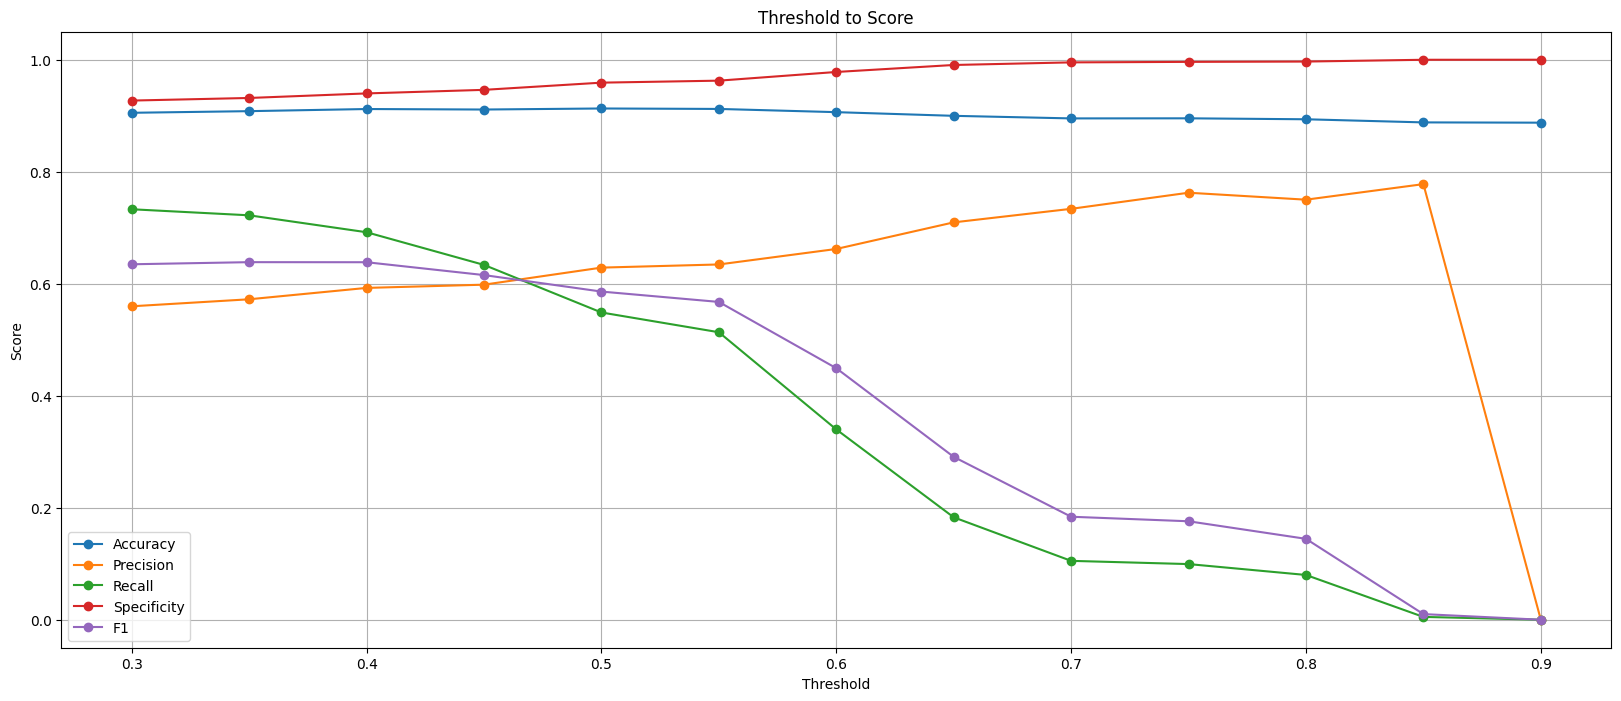

In [46]:
plot_model(cv1, X_test, y_test)

In [51]:
# y_pred_1 = cv1.predict(X_test)
probs = cv1.predict_proba(X_test)
y_pred_1 = np.where(probs[:, 1] >= 0.50,  'yes','no')

## 5.4. Scoring

### Accuracy
Q) Out of the predictions made by the model, what percent is correct?
<div align="center">
$Accuracy =\Large \frac{(TP+TN))}{(TP+TN+FP+FN)}$
</div>

In [52]:
accuracy = accuracy_score(y_test, y_pred_1)
print("Accuracy:", accuracy)

Accuracy: 0.9128429230395727


### Precision Score
Q) Out of all the YES predictions, how many of them were correct?
<div align="center">
$Precision = \Large\frac{TP}{TP+FP}$
</div>

In [53]:
p_score = precision_score(y_test, y_pred_1,pos_label='yes')
print("Precision Score:", p_score)

Precision Score: 0.6287128712871287


### Recall Score
Q) Of all the actual positive cases, how many did the model capture?
<div align="center">
$Recall = \Large\frac{TP}{TP+FN}$
</div>

In [54]:
r_score = recall_score(y_test, y_pred_1,pos_label='yes')
print("Recall Score", r_score)

Recall Score 0.5485961123110151


### F1 Score
<div align="center">
$F1 = \Large\frac{2*TP}{2*TP+FP+FN}$
</div>

In [55]:
f_1_score = f1_score(y_test, y_pred_1, pos_label='yes')
print("F1 Score", f_1_score)

F1 Score 0.5859284890426759


In [56]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_1).ravel()
tn, fp, fn, tp

(np.int64(10518), np.int64(450), np.int64(627), np.int64(762))

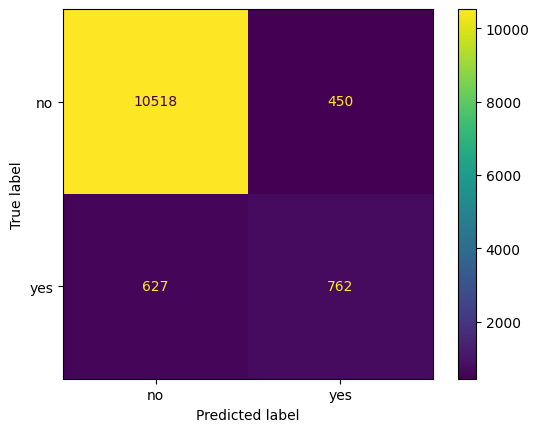

In [57]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_1);

# 6. Pipeline - 2

<div class="alert alert-block alert-info">
- Metric used here is "fbeta_score"<br>    
- Lastly used DecisionTreeClassifier  <br>
- Followed by which we are doing Feature Selection <br>    
- HyperParameter Tuning using GridSearchCV<br>
</div>

In [58]:
pipeline2 = Pipeline([
    ('transformer', transformer),     
    ('feature_selection', SelectFromModel(estimator=LogisticRegression(random_state=43, max_iter = 1000, C= 0.1, penalty= 'l1',solver= 'liblinear'))),
    ('classifier', DecisionTreeClassifier(random_state = 42))
])

## 6.1 GridSearchCV

In [59]:
params2 = [
    {
         'classifier__criterion': ["gini", "entropy"],
         'classifier__max_depth': list(range(8, 14, 1)),
         'classifier__min_samples_split': np.linspace(0.15, 0.25, 10)
    },   
    {
        'classifier__criterion': ["gini", "entropy"],        
        'classifier__min_samples_split': np.linspace(0.02,0.06,4),
    },
    {
        'classifier__criterion': ["gini", "entropy"],
        'classifier__min_samples_leaf': [0.02,0.04,0.06]
    },
    {
        'classifier__criterion': ["gini", "entropy"],
        'classifier__max_leaf_nodes':list(range(54, 66, 2)),
    },
     {
         'classifier__criterion': ["gini", "entropy"],  
         'classifier__max_depth': list(range(8, 14, 1)),
     }
]

In [60]:
cv2 = GridSearchCV(pipeline2, param_grid=params2, n_jobs=-1, scoring=make_scorer(fbeta_score, beta=2, pos_label='yes'))

## 6.2. Fitting the LogisticRegression Model

In [61]:
cv2.fit(X_train, y_train);

In [62]:
pprint(cv2.best_params_)

{'classifier__criterion': 'entropy', 'classifier__max_depth': 8}


## 6.3. Predictions

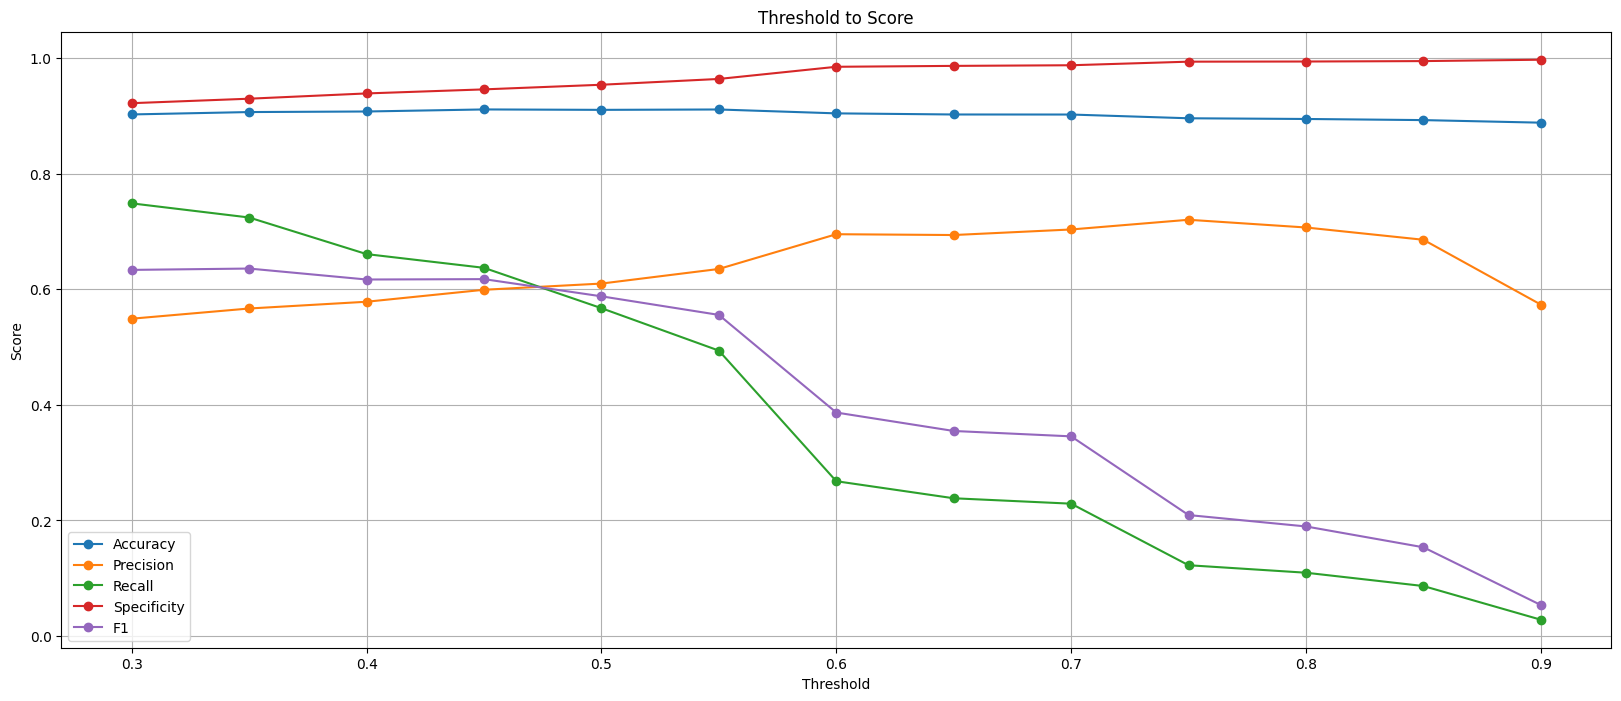

In [63]:
plot_model(cv2, X_test, y_test)

In [64]:
# y_pred_2 = cv2.predict(X_test)
probs = cv2.predict_proba(X_test)
y_pred_2 = np.where(probs[:, 1] >= 0.50,  'yes','no')

## 5.4. Scoring

In [65]:
accuracy = accuracy_score(y_test, y_pred_2)
print("Accuracy:", accuracy)

Accuracy: 0.9097677429796877


In [66]:
p_score = precision_score(y_test, y_pred_2,pos_label='yes')
print("Precision Score:", p_score)

Precision Score: 0.6033182503770739


In [67]:
r_score = recall_score(y_test, y_pred_2,pos_label='yes')
print("Recall Score", r_score)

Recall Score 0.5759539236861051


In [68]:
f_1_score = f1_score(y_test, y_pred_2, pos_label='yes')
print("F1 Score", f_1_score)

F1 Score 0.5893186003683242


In [69]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_2).ravel()
tn, fp, fn, tp

(np.int64(10442), np.int64(526), np.int64(589), np.int64(800))

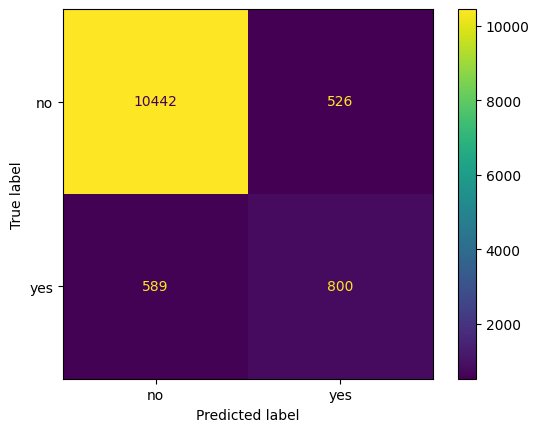

In [70]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_2, values_format='d');

# 7. Pipeline - 3

<div class="alert alert-block alert-info">
- Metric used here is "fbeta_score"<br>    
- Lastly used DecisionTreeClassifier  <br>
- Followed by which we are doing Feature Selection <br>    
- HyperParameter Tuning using GridSearchCV<br>
</div>

In [71]:
pipeline3 = Pipeline([
    ('transformer', transformer),     
    ('feature_selection', SelectFromModel(estimator=LogisticRegression(random_state=43, max_iter = 1000, C= 0.1, penalty= 'l1',solver= 'liblinear'))),
    ('classifier', DecisionTreeClassifier(random_state = 42))
])

## 7.1 GridSearchCV

In [72]:
params3 = [
    {
         'classifier__criterion': ["gini", "entropy"],
         'classifier__max_depth': list(range(8, 14, 1)),
         'classifier__min_samples_split': np.linspace(0.15, 0.25, 10)
    },   
    {
        'classifier__criterion': ["gini", "entropy"],        
        'classifier__min_samples_split': np.linspace(0.02,0.06,4),
    },
    {
        'classifier__criterion': ["gini", "entropy"],
        'classifier__min_samples_leaf': [0.02,0.04,0.06]
    },
    {
        'classifier__criterion': ["gini", "entropy"],
        'classifier__max_leaf_nodes':list(range(54, 66, 2)),
    },
     {
         'classifier__criterion': ["gini", "entropy"],  
         'classifier__max_depth': list(range(8, 14, 1)),
     }
]

In [73]:
cv3 = GridSearchCV(pipeline3, param_grid=params3, n_jobs=-1, scoring=make_scorer(recall_score, pos_label='yes'))

## 7.2. Fitting the LogisticRegression Model

In [74]:
cv3.fit(X_train, y_train);

In [75]:
pprint(cv3.best_params_)

{'classifier__criterion': 'gini',
 'classifier__min_samples_split': np.float64(0.04666666666666666)}


## 7.3. Predictions

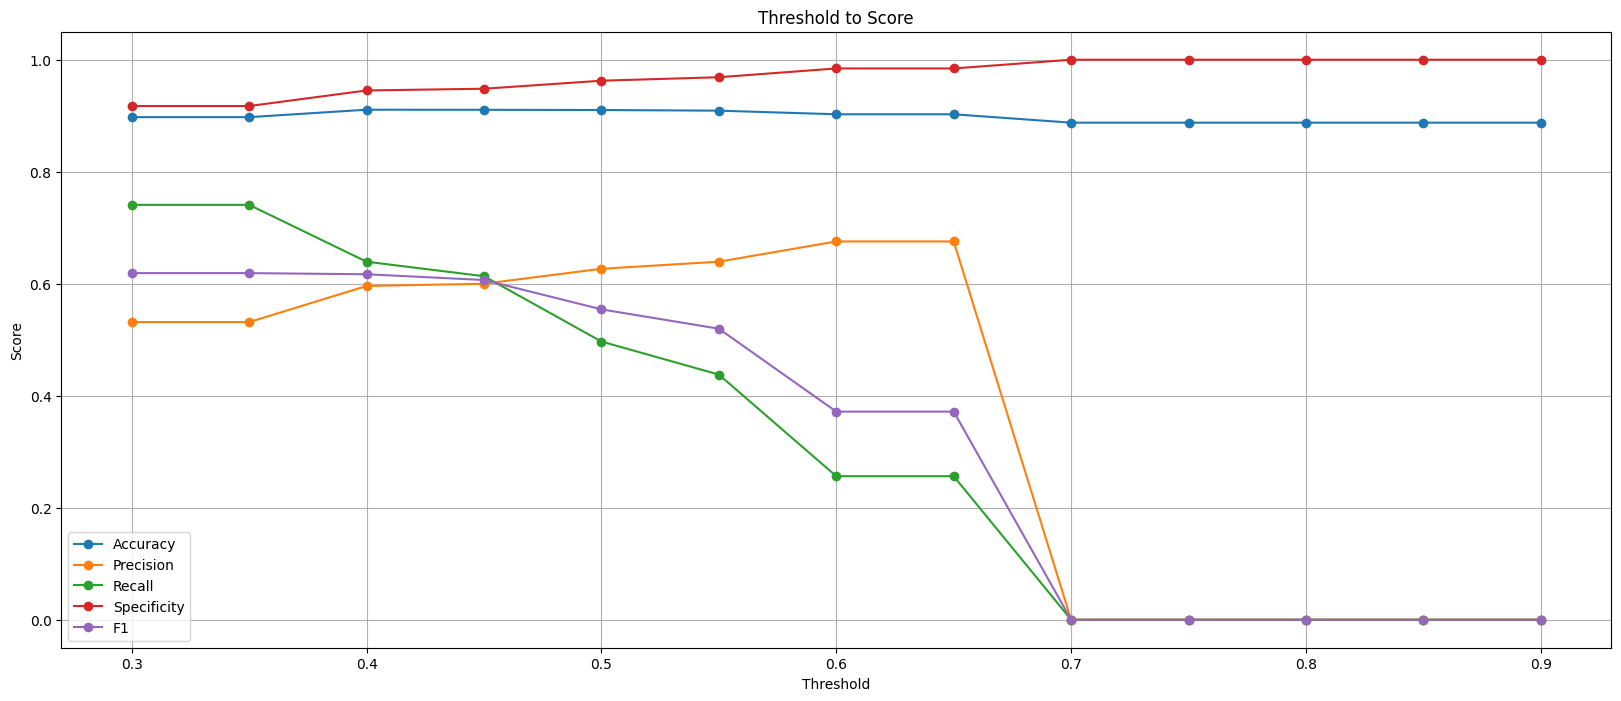

In [76]:
plot_model(cv3, X_test, y_test)

In [77]:
# y_pred_3 = cv3.predict(X_test)
probs = cv3.predict_proba(X_test)
y_pred_3 = np.where(probs[:, 1] >= 0.45,  'yes','no')

## 7.4. Scoring

In [78]:
accuracy = accuracy_score(y_test, y_pred_3)
print("Accuracy:", accuracy)

Accuracy: 0.9105770008901837


In [79]:
p_score = precision_score(y_test, y_pred_3,pos_label='yes')
print("Precision Score:", p_score)

Precision Score: 0.6


In [80]:
r_score = recall_score(y_test, y_pred_3,pos_label='yes')
print("Recall Score", r_score)

Recall Score 0.6133909287257019


In [81]:
f_1_score = f1_score(y_test, y_pred_3, pos_label='yes')
print("F1 Score", f_1_score)

F1 Score 0.6066215735137059


In [82]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_3).ravel()
tn, fp, fn, tp

(np.int64(10400), np.int64(568), np.int64(537), np.int64(852))

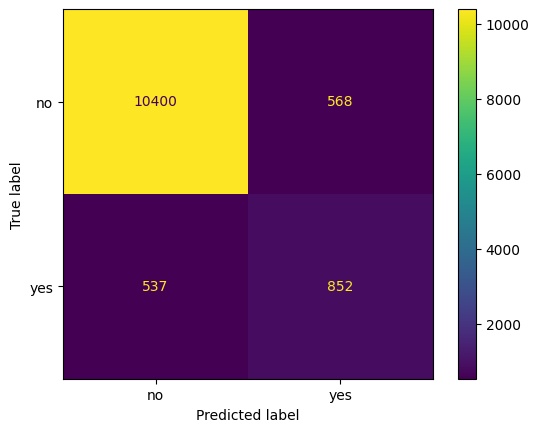

In [83]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_3, values_format='d');

# 8. Pipeline - 4

<div class="alert alert-block alert-info">
- Metric used here is "fbeta_score"<br>    
- Lastly used DecisionTreeClassifier  <br>
- HyperParameter Tuning using GridSearchCV<br>
</div>

In [84]:
pipeline4 = Pipeline([
    ('transformer', transformer),     
    ('classifier', DecisionTreeClassifier(random_state = 42, class_weight='balanced'))
])

## 8.1 GridSearchCV

In [85]:
params4 = [
    {
         'classifier__criterion': ["gini", "entropy"],
         'classifier__max_depth': list(range(8, 14, 1)),
         'classifier__min_samples_split': np.linspace(0.15, 0.25, 10)
    },   
    {
        'classifier__criterion': ["gini", "entropy"],        
        'classifier__min_samples_split': np.linspace(0.02,0.06,4),
    },
    {
        'classifier__criterion': ["gini", "entropy"],
        'classifier__min_samples_leaf': [0.02,0.04,0.06]
    },
    {
        'classifier__criterion': ["gini", "entropy"],
        'classifier__max_leaf_nodes':list(range(54, 66, 2)),
    },
     {
         'classifier__criterion': ["gini", "entropy"],  
         'classifier__max_depth': list(range(8, 14, 1)),
     }
]

In [86]:
cv4 = GridSearchCV(pipeline4, param_grid=params4, n_jobs=-1, scoring=make_scorer(fbeta_score, beta=2, pos_label='yes'))

## 8.2. Fitting the LogisticRegression Model

In [87]:
cv4.fit(X_train, y_train);

In [88]:
pprint(cv4.best_params_)

{'classifier__criterion': 'gini', 'classifier__max_leaf_nodes': 58}


## 8.3. Predictions

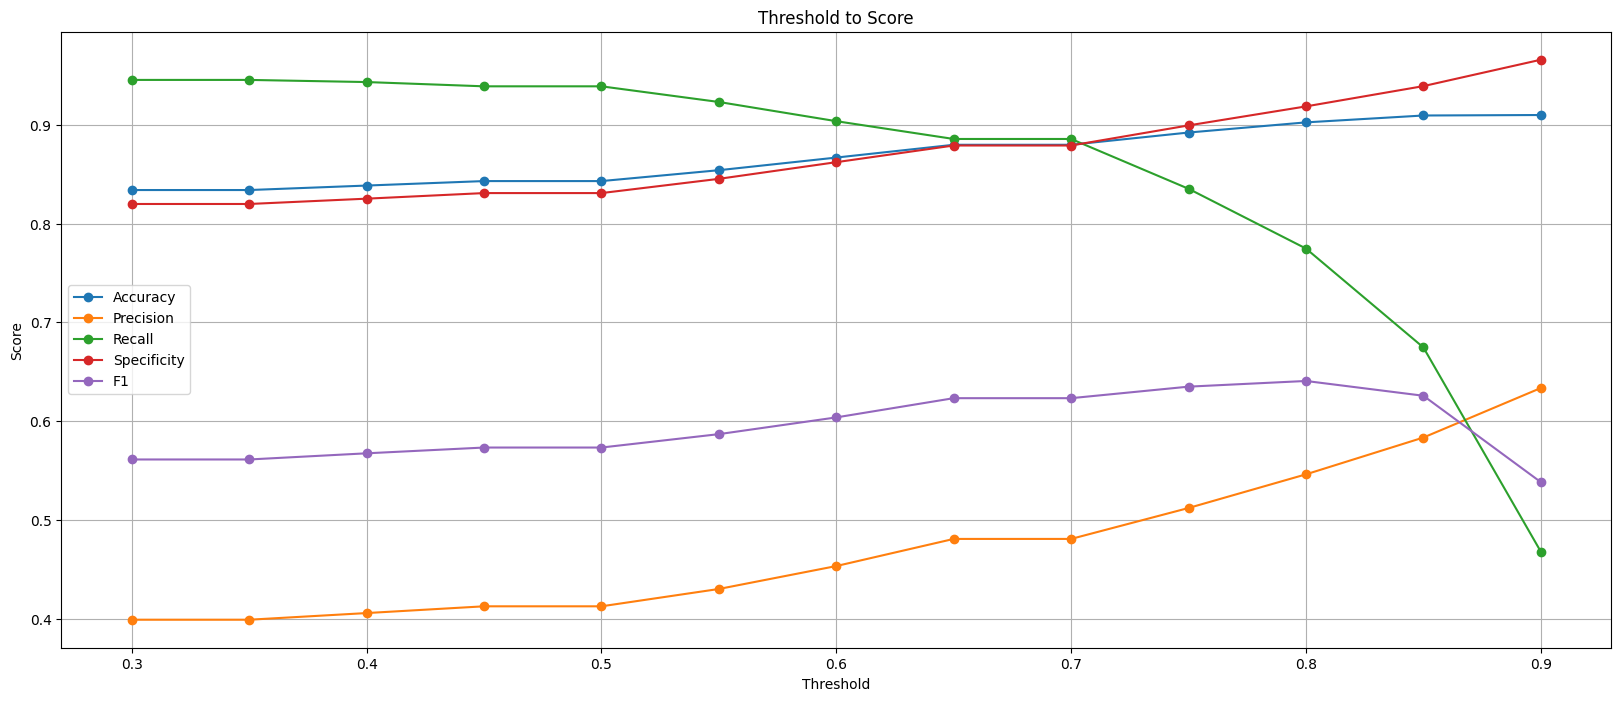

In [89]:
plot_model(cv4, X_test, y_test)

In [90]:
# y_pred_4 = cv4.predict(X_test)
probs = cv4.predict_proba(X_test)
y_pred_4 = np.where(probs[:, 1] >= 0.75,  'yes','no')

## 8.4. Scoring

In [91]:
accuracy = accuracy_score(y_test, y_pred_4)
print("Accuracy:", accuracy)

Accuracy: 0.8920449947398236


In [92]:
p_score = precision_score(y_test, y_pred_4,pos_label='yes')
print("Precision Score:", p_score)

Precision Score: 0.5121412803532008


In [93]:
r_score = recall_score(y_test, y_pred_4,pos_label='yes')
print("Recall Score", r_score)

Recall Score 0.8351331893448524


In [94]:
f_1_score = f1_score(y_test, y_pred_4, pos_label='yes')
print("F1 Score", f_1_score)

F1 Score 0.6349206349206349


In [95]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_1).ravel()
tn, fp, fn, tp

(np.int64(10518), np.int64(450), np.int64(627), np.int64(762))

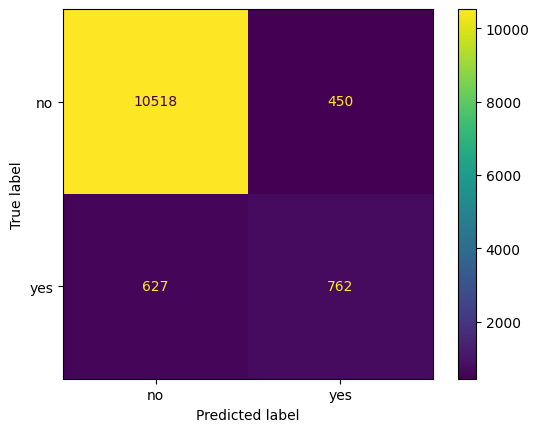

In [96]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_1);

# 9. Pipeline - 5

<div class="alert alert-block alert-info">
- Metric used here is "fbeta_score"<br>    
- Lastly used DecisionTreeClassifier  <br>
- Followed by which we are doing Feature Selection <br>    
- HyperParameter Tuning using GridSearchCV<br>
</div>

In [97]:
pipeline5 = Pipeline([
    ('transformer', transformer),     
    ('feature_selection', SelectFromModel(estimator=LogisticRegression(random_state=43, max_iter = 1000, C= 0.1, penalty= 'l1',solver= 'liblinear'))),
    ('classifier', DecisionTreeClassifier(random_state = 42, class_weight='balanced'))
])

## 9.1 GridSearchCV

In [98]:
params5 = [
    {
        'classifier__criterion': ["gini", "entropy"],
        'classifier__max_depth': list(range(8, 14, 1)),
        'classifier__min_samples_split': np.linspace(0.15, 0.25, 10)
    },   
    {
        'classifier__criterion': ["gini", "entropy"],        
        'classifier__min_samples_split': np.linspace(0.02,0.06,4),
    },
    {
        'classifier__criterion': ["gini", "entropy"],
        'classifier__min_samples_leaf': [0.02,0.04,0.06]
    },
    {
        'classifier__criterion': ["gini", "entropy"],
        'classifier__max_leaf_nodes':list(range(54, 66, 2)),
    },
     {
         'classifier__criterion': ["gini", "entropy"],  
         'classifier__max_depth': list(range(8, 14, 1)),
     }
]

In [99]:
cv5 = GridSearchCV(pipeline5, param_grid=params5, n_jobs=-1, scoring=make_scorer(fbeta_score, beta=2, pos_label='yes'))

## 9.2. Fitting the LogisticRegression Model

In [100]:
cv5.fit(X_train, y_train);

In [101]:
pprint(cv5.best_params_)

{'classifier__criterion': 'entropy', 'classifier__max_leaf_nodes': 64}


## 9.3. Predictions

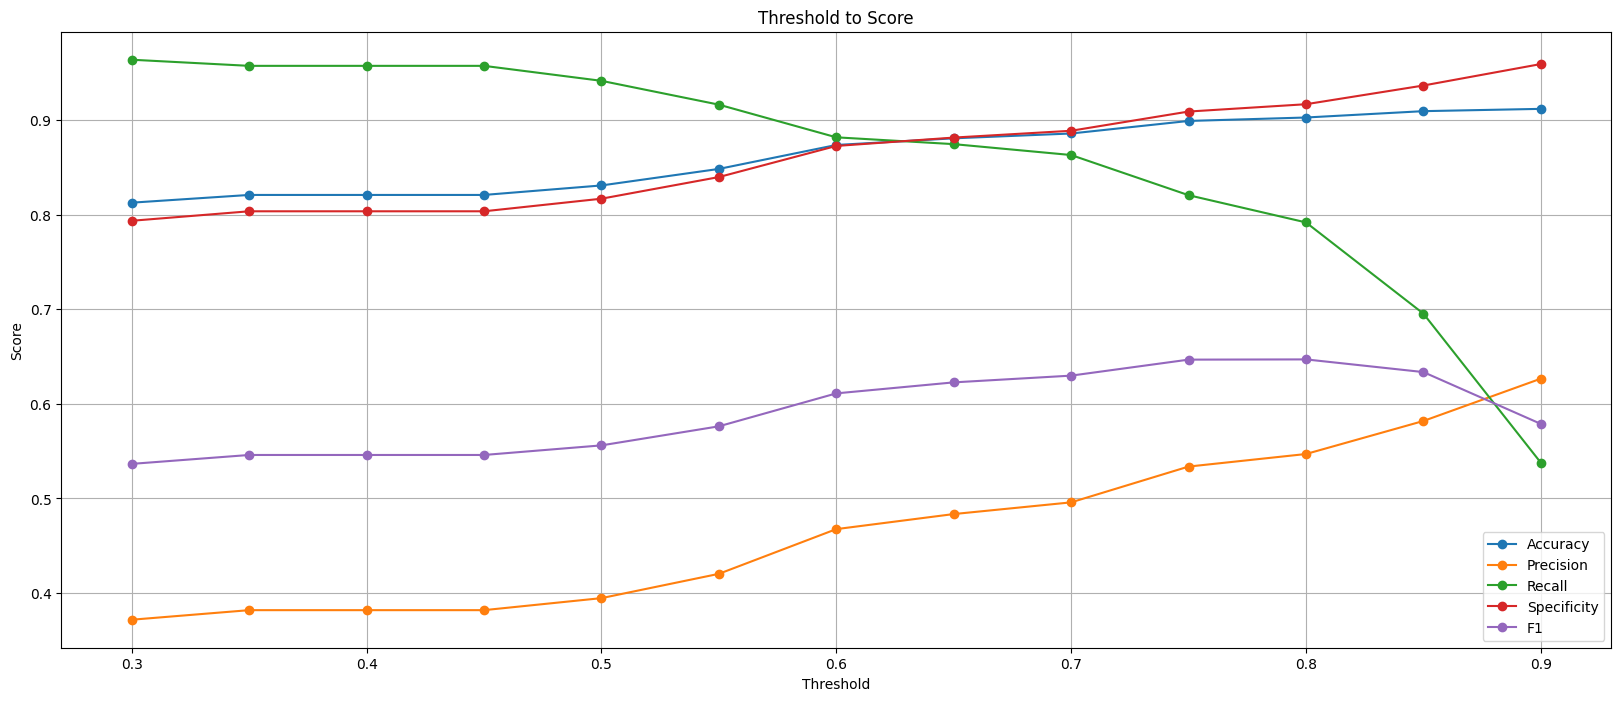

In [102]:
plot_model(cv5, X_test, y_test)

In [103]:
# y_pred_5 = cv5.predict(X_test)
probs = cv5.predict_proba(X_test)
y_pred_5 = np.where(probs[:, 1] >= 0.77,  'yes','no')

## 9.4. Scoring

In [104]:
accuracy = accuracy_score(y_test, y_pred_5)
print("Accuracy:", accuracy)

Accuracy: 0.8992473901432386


In [105]:
p_score = precision_score(y_test, y_pred_5,pos_label='yes')
print("Precision Score:", p_score)

Precision Score: 0.5337078651685393


In [106]:
r_score = recall_score(y_test, y_pred_5,pos_label='yes')
print("Recall Score", r_score)

Recall Score 0.8207343412526998


In [107]:
f_1_score = f1_score(y_test, y_pred_5, pos_label='yes')
print("F1 Score", f_1_score)

F1 Score 0.6468085106382979


In [108]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_5).ravel()
tn, fp, fn, tp

(np.int64(9972), np.int64(996), np.int64(249), np.int64(1140))

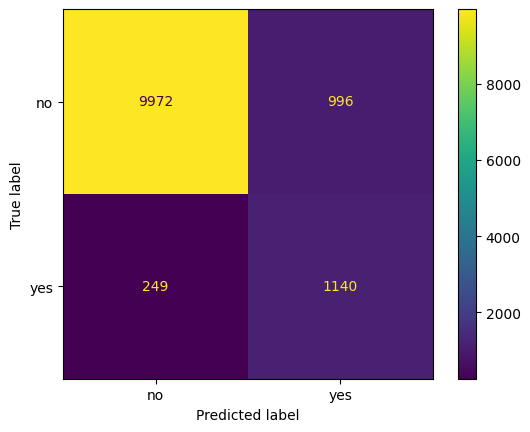

In [109]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_5);

<div class="alert alert-block alert-success">
    <h1>DecisionTreeClassification - Conclusion</h1>
</div>

|                           | Model 1     | Model 2     | Model 3      | Model 4     | Model 5     |
| :------------------------ | :---------- | :---------- | ------------ | ----------- | ----------- |
| Metric                    | fbeta_score | fbeta_score | Recall_score | fbeta_score | fbeta_score |
| Data Sampling Algorithms  | No          | No          | No           | No          | No          |
| Cost-Sensitive Algorithms | No          | No          | No           | Yes         | Yes         |
| Feature Selection         | No          | Yes         | Yes          | No          | Yes         |
| Threshold                 | 0.50        | 0.50        | 0.45         | 0.75        | 0.77        |
| Accuracy                  | 0.9128      | 0.9114      | 0.9114       | 0.8429      | 0.8385      |
| Precision Score           | 0.6287      | 0.6080      | 0.6080       | 0.4126      | 0.4065      |
| Recall Score              | 0.5485      | 0.5975      | 0.5975       | 0.9388      | 0.9488      |
| F1 Score                  | 0.5859      | 0.6027      | 0.6027       | 0.5733      | 0.5692      |

Both **Model 4** and **Model 5** have fantastic recall score, but low **Precision Score**. Rest 3 Models have performed around average with respect to Precision and Recall. **Model 3** performed worst, after the threshold of 70, all the F1 Score, Recall and Precision score dropped to 0